# Pasqal's emulators: emu-mps and emu-sv

In [1]:
from pulser import Register
from pulser import Sequence, Pulse
from pulser.devices import MockDevice

/Users/maurodarcangelo/Documents/Pasqal/EPITA_2025/.venv/lib/python3.10/site-packages/pulser/register/register.py:58: DeprecationWarning: Usage of `int`s or any non-`str`types as `QubitId`s will be deprecated. Define your `QubitId`s as `str`s, prefer setting `prefix='q'` when using classmethods, as that will become the new default once `int` qubit IDs become invalid.
  super().__init__(qubits, **kwargs)
/Users/maurodarcangelo/Documents/Pasqal/EPITA_2025/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


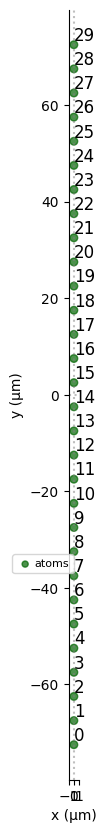

In [4]:
# Let's create a large register with 30 qubits, that is not possible to simulate with standard tools 

spacing = 5
coordinates = [[0, i*spacing] for i in range(30)]
register = Register.from_coordinates(coordinates)
register.draw()

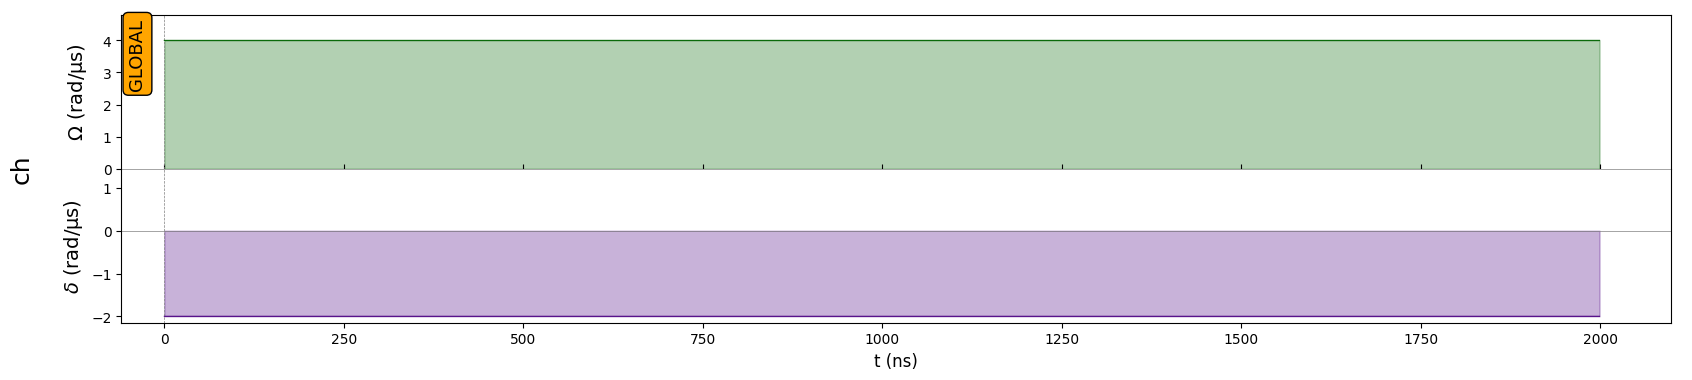

In [5]:
seq = Sequence(register, MockDevice)

pulse = Pulse.ConstantPulse(
    duration=2000, # nanoseconds
    amplitude=4, # rad/microsecond
    detuning=-2, #rad/microsecond
    phase=0
)

seq.declare_channel("ch", "rydberg_global")
seq.add(pulse, "ch")
seq.draw()

In [7]:
# the system is too large to simualate normally.
# we will use tensor networks instead.
# Pasqal has edeveloped a tensor network emulator fully compatible with Pulser, called emu-mps

from emu_mps import MPSBackend, MPSConfig, BitStrings

bitstrings = BitStrings(evaluation_times=[1], num_shots=1000)
config = MPSConfig(
    observables=[bitstrings],
)
simulation = MPSBackend(seq, config=config) 

In [8]:
# the simulation will take a couple of minutes
results = simulation.run()

In [9]:
samples = results.get_result(bitstrings, 1)
samples

Counter({'000001010000000010100100100000': 1,
         '000010010000010100010000010000': 1,
         '001000000010100000100100000001': 1,
         '001010010010001001000101010000': 1,
         '000101000000101000010001000001': 1,
         '010010010010010010001000010000': 1,
         '100100001000101001001000101001': 1,
         '100000000100001001000100010000': 1,
         '100010000001000100101000010010': 1,
         '001010100100010000000001000010': 1,
         '100100001010100001001000100001': 1,
         '000100000101001000010000100010': 1,
         '001000010000010010000001010000': 1,
         '100010010001010000001001001000': 1,
         '010100000001010000101001001001': 1,
         '001000100001000100010001000100': 1,
         '000010001000001001010001010010': 1,
         '000100101000000101000000010001': 1,
         '000100100101000000100100010001': 1,
         '001010010000100100101001001000': 1,
         '001000010000000100100100100001': 1,
         '000100100010100001010001

/Users/maurodarcangelo/Documents/Pasqal/EPITA_2025/.venv/lib/python3.10/site-packages/pulser/register/register.py:58: DeprecationWarning: Usage of `int`s or any non-`str`types as `QubitId`s will be deprecated. Define your `QubitId`s as `str`s, prefer setting `prefix='q'` when using classmethods, as that will become the new default once `int` qubit IDs become invalid.
  super().__init__(qubits, **kwargs)


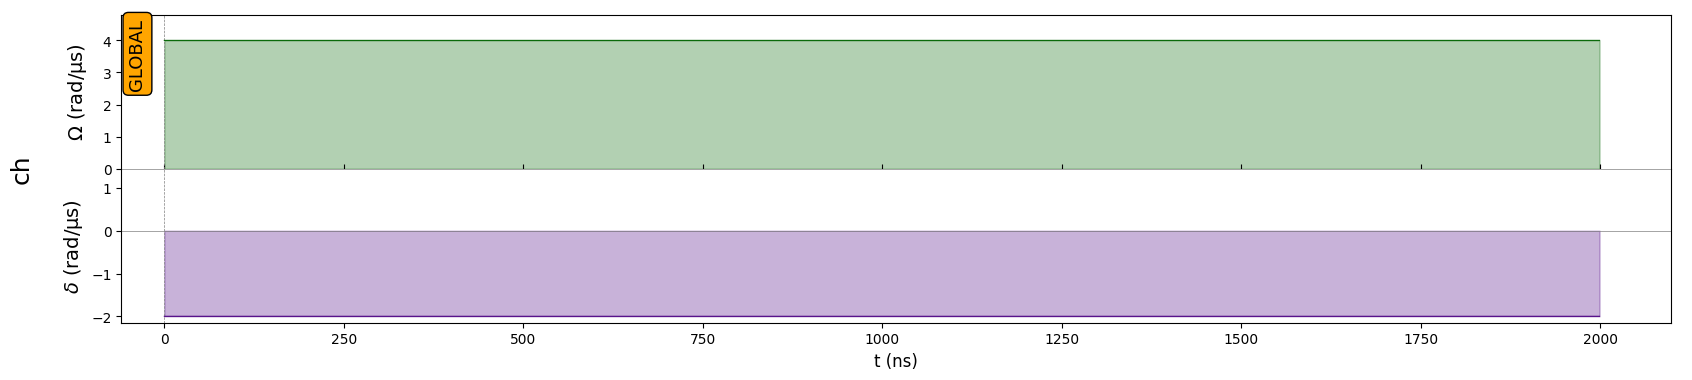

In [10]:
# The other emulator developed by Pasqal is called emu-sv.
# emu-sv is a state vector emulator, it's fast, but cannot simulate more than 20 qubits

spacing = 5
coordinates = [[0, i*spacing] for i in range(19)]
register = Register.from_coordinates(coordinates)


seq = Sequence(register, MockDevice)

pulse = Pulse.ConstantPulse(
    duration=2000, # nanoseconds
    amplitude=4, # rad/microsecond
    detuning=-2, #rad/microsecond
    phase=0
)

seq.declare_channel("ch", "rydberg_global")
seq.add(pulse, "ch")
seq.draw()

In [11]:
# the syntax for emu-sv is exacly the same as emu-mps

from emu_sv import SVBackend, SVConfig, BitStrings
from pulser.noise_model import NoiseModel

bitstrings = BitStrings(evaluation_times=[1], num_shots=1000)

config = SVConfig(
    observables=[bitstrings],
)
simulation = SVBackend(seq, config=config) 

In [12]:
results = simulation.run()

In [13]:
samples_sv = results.get_result(bitstrings, 1)
samples_sv

Counter({'0000010100000010010': 4,
         '0001000010001000100': 4,
         '0001000010000100001': 3,
         '0100100000000100000': 3,
         '0010100001001010000': 3,
         '0010100000100010000': 3,
         '0001000100100100100': 3,
         '0010100000001010000': 3,
         '0010000100010001001': 3,
         '0010010001001001001': 3,
         '0000101000000101000': 3,
         '0000010010000001000': 3,
         '0010001000100001000': 3,
         '0010010010010001000': 3,
         '1000010001001000001': 2,
         '0001000010001000000': 2,
         '0000010000100101001': 2,
         '0000010010000010001': 2,
         '0010000100100010000': 2,
         '1001000001010001000': 2,
         '0001010010000010100': 2,
         '0100101000100100100': 2,
         '0001000010010001000': 2,
         '0000100010100000100': 2,
         '0000010100001001000': 2,
         '0100010000100010010': 2,
         '0010000000100010100': 2,
         '0010010010000010010': 2,
         '0010100000

# Simulate with noise

In [17]:
# To simulate the effect of errors and noise, we can use the module noise_model from Pulser

from emu_sv import SVBackend, SVConfig, BitStrings
from pulser.noise_model import NoiseModel


bitstrings = BitStrings(evaluation_times=[1], num_shots=1000)

noise_model = NoiseModel(
            p_false_pos=0.03, # probability of false positive in measurement (reading a 1 instead of a zero)
            p_false_neg=0.1, # probability of false negative in measurement (reading a 0 instead of a 1)
            #temperature=20, # temperature of the atoms (microkelvins)
            #trap_depth=150, # uncertainty of qubit position off-plane (microkelvins)
            #trap_waist=1, # uncertainty of qubit position in-plane (micrometers)
        )

config = SVConfig(
    observables=[bitstrings],
    noise_model=noise_model,
)
simulation = SVBackend(seq, config=config) 

In [18]:
results = simulation.run()

In [19]:
samples_sv = results.get_result(bitstrings, 1)
samples_sv

Counter({'0001001000000010010': 4,
         '0010001001001000100': 4,
         '1001010000100010000': 4,
         '0000001000000001000': 3,
         '0010000010000001000': 3,
         '0000100101000010010': 3,
         '1000100010100001000': 3,
         '0000001001000000001': 2,
         '0000101000000101000': 2,
         '1000001000010000100': 2,
         '0000001010000100100': 2,
         '0010000100001000001': 2,
         '0010000000000010000': 2,
         '0010000000100000000': 2,
         '0001000000000010000': 2,
         '0101000000100010000': 2,
         '0001000001000010000': 2,
         '1000100100000010010': 2,
         '0100000000010000000': 2,
         '0100000000101000000': 2,
         '0100010100000001000': 2,
         '0001010000010010100': 2,
         '0010010010010001000': 2,
         '1001001010000000100': 2,
         '0101000000010100000': 2,
         '0010000000101001000': 2,
         '0000010010000010000': 2,
         '0100100000100101000': 2,
         '0001010010